In [1]:
from keras.layers import Conv2D , MaxPool2D ,ZeroPadding2D , UpSampling2D ,Reshape, Input ,Dense, Activation,Flatten
from keras.utils import np_utils
from keras.models import Model

In [2]:
e = 30

inp = Input(shape = (50,50,3))
conv1 = Conv2D(32 , (3,3) , activation = "relu")(inp)
conv2 = Conv2D(16 , (3,3),activation="relu")(conv1)
mp1 = MaxPool2D((2,2))(conv2)
conv3 = Conv2D(8,(3,3),activation="relu")(mp1)

flat = Flatten()(conv3)
emb = Dense(e , activation="sigmoid")(flat)
fc1 = Dense(900 , activation="sigmoid")(emb)

res1 = Reshape((10,10,9))(fc1)
ups1 = UpSampling2D((2,2))(res1)
zrp5 = ZeroPadding2D((1,1))(ups1)

conv4 = Conv2D(16,(3,3),padding="same" , activation ="relu")(zrp5)
zrp1 = ZeroPadding2D((1,1))(conv4)

conv5 = Conv2D(32,(3,3),padding="same" , activation ="relu")(zrp1)
ups2 = UpSampling2D((2,2))(conv5)

zrp3 = ZeroPadding2D((1,1))(ups2)
conv6 = Conv2D(3,(3,3),padding="same" , activation="relu")(zrp3)

In [3]:
c_a_e = Model(inputs=inp, outputs=conv6)
c_a_e.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 16)        4624      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 8)         1160      
_________________________________________________________________
flatten (Flatten)            (None, 3528)              0         
_________________________________________________________________
dense (Dense)                (None, 30)               

In [4]:
c_a_e.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [5]:
for i in enumerate(c_a_e.layers):
    print(i)

(0, <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f08c6590b80>)
(1, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f08c6590af0>)
(2, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f08c6516e80>)
(3, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f08c6533730>)
(4, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f08c6533eb0>)
(5, <tensorflow.python.keras.layers.core.Flatten object at 0x7f08c6533460>)
(6, <tensorflow.python.keras.layers.core.Dense object at 0x7f08c5d0bca0>)
(7, <tensorflow.python.keras.layers.core.Dense object at 0x7f08c4276a30>)
(8, <tensorflow.python.keras.layers.core.Reshape object at 0x7f08c4276ee0>)
(9, <tensorflow.python.keras.layers.convolutional.UpSampling2D object at 0x7f08c427abb0>)
(10, <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f08c427afd0>)
(11, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f08c4287d00>)
(12, <tenso

In [6]:
encoder = Model(inputs=inp,outputs=emb)
encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 16)        4624      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 8)         1160      
_________________________________________________________________
flatten (Flatten)            (None, 3528)              0         
_________________________________________________________________
dense (Dense)                (None, 30)               

In [23]:
decoder_input = Input(shape=(e,))
dec_layer = c_a_e.layers[7](decoder_input)

for i in range(8, len(c_a_e.layers)):
    dec_layer = c_a_e.layers[i](dec_layer)
decoder = Model(inputs=decoder_input, outputs=dec_layer)
decoder.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 900)               27900     
_________________________________________________________________
reshape (Reshape)            (None, 10, 10, 9)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 20, 20, 9)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 22, 22, 9)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 16)        1312      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 24, 24, 16)       

In [8]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping 
from keras.models import load_model

In [9]:
def training_dataset_(
    file_path,
    image_per_batch,
    start_row,
    ):
    df = pd.read_csv(file_path)[start_row:start_row+image_per_batch]
    
#     df = df.drop('Unnamed: 0',axis=1)
    df = df.drop('age',axis=1)

    y = get_data_from_local(df)
    x = df.drop('image',axis=1)
    
    x = x.astype('float64')
    
    return x.values , y

In [10]:
def get_data_from_local(X_train):
    X_data =[]
    for file in tqdm(X_train['image']):
        file = file.replace('age_detection','dataset-code')
#         print(file)
        face = cv2.imread(file,cv2.IMREAD_COLOR)
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face =cv2.resize(face, (50,50))
#         face = np.expand_dims(face, axis=2)
        face = np.asarray(face)
        face = face.astype('float32')
        face /= 255
        X_data.append(face)
    return np.array(X_data)

In [11]:
def training(
    start_row,
    number_of_labels,
    file_path,
    image_per_batch,
    max_limit,
    path_of_model
):

    checkpoint = ModelCheckpoint(filepath=path_of_model,
                             monitor='val_accuracy',
                             save_format='tf',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )
    early_stopping_monitor = EarlyStopping(patience=4,verbose=1) 
    
    for x in range(start_row,max_limit,image_per_batch):
        
        print()
        print('**********{} -- {} out of {}************'.format(x,x+image_per_batch,max_limit))
        print()
    
        X_train , y_train   =   training_dataset_(
                        file_path = file_path,
                        start_row = x,
                        image_per_batch = image_per_batch
        )
                    
        F_mnist = c_a_e.fit(y_train,y_train,
                            shuffle=True,
                            epochs=30,
                            validation_split=0.2,
                            batch_size=64,
                            callbacks=[checkpoint,early_stopping_monitor]
       )


In [12]:
training(
    start_row = 0,
    number_of_labels = 3,
    file_path = '../facial_prediction/dataset_200.csv',
    image_per_batch = 2000,
    max_limit = 22000,
    path_of_model = 'final50_cnn_checkpoint.tf'
)

  6%|▋         | 129/2000 [00:00<00:01, 1284.77it/s]


**********0 -- 2000 out of 22000************



100%|██████████| 2000/2000 [00:01<00:00, 1280.95it/s]


(2000, 50, 50, 3)
Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.4787
Epoch 00001: val_accuracy improved from -inf to 0.70610, saving model to final50_cnn_checkpoint.tf
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: final50_cnn_checkpoint.tf/assets
25/25 [==============================] - 13s 539ms/step - loss: 0.1209 - accuracy: 0.4787 - val_loss: 0.0681 - val_accuracy: 0.7061
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.0598 - accuracy: 0.8589
Epoch 00002: val_accuracy improved from 0.70610 to 0.91199, saving model to final50_cnn_checkpoint.tf
INFO:tensorflow:Assets written to: final50_cnn_checkpoint.tf/assets
25/25 [==============================] - 14s 555ms/step - loss: 0.0598 - accuracy: 0.8589 -

Epoch 24/30
25/25 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9192
Epoch 00024: val_accuracy did not improve from 0.92491
25/25 [==============================] - 10s 397ms/step - loss: 0.0167 - accuracy: 0.9192 - val_loss: 0.0169 - val_accuracy: 0.9162
Epoch 25/30
25/25 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9183
Epoch 00025: val_accuracy did not improve from 0.92491
25/25 [==============================] - 12s 473ms/step - loss: 0.0164 - accuracy: 0.9183 - val_loss: 0.0167 - val_accuracy: 0.9139
Epoch 26/30
25/25 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9185
Epoch 00026: val_accuracy did not improve from 0.92491
25/25 [==============================] - 10s 420ms/step - loss: 0.0168 - accuracy: 0.9185 - val_loss: 0.0165 - val_accuracy: 0.9178
Epoch 27/30
25/25 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9180
Epoch 00027: val_accuracy did not improve from 0.92491
25/2

  0%|          | 10/2000 [00:00<00:20, 95.64it/s]


**********2000 -- 4000 out of 22000************



100%|██████████| 2000/2000 [00:21<00:00, 95.16it/s] 


(2000, 50, 50, 3)
Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9154
Epoch 00001: val_accuracy did not improve from 0.92491
25/25 [==============================] - 11s 430ms/step - loss: 0.0160 - accuracy: 0.9154 - val_loss: 0.0156 - val_accuracy: 0.9182
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9161
Epoch 00002: val_accuracy did not improve from 0.92491
25/25 [==============================] - 11s 435ms/step - loss: 0.0158 - accuracy: 0.9161 - val_loss: 0.0150 - val_accuracy: 0.9139
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9164
Epoch 00003: val_accuracy did not improve from 0.92491
25/25 [==============================] - 12s 470ms/step - loss: 0.0157 - accuracy: 0.9164 - val_loss: 0.0153 - val_accuracy: 0.9150
Epoch 4/30
25/25 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9165
Epoch 00004: val_accuracy did not improve fro

  0%|          | 10/2000 [00:00<00:20, 97.75it/s]

Epoch 00004: early stopping

**********4000 -- 6000 out of 22000************



100%|██████████| 2000/2000 [00:21<00:00, 95.19it/s] 


(2000, 50, 50, 3)
Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9185
Epoch 00001: val_accuracy did not improve from 0.92491
25/25 [==============================] - 10s 409ms/step - loss: 0.0149 - accuracy: 0.9185 - val_loss: 0.0143 - val_accuracy: 0.9154
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9190
Epoch 00002: val_accuracy did not improve from 0.92491
25/25 [==============================] - 10s 417ms/step - loss: 0.0150 - accuracy: 0.9190 - val_loss: 0.0143 - val_accuracy: 0.9189
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9192
Epoch 00003: val_accuracy did not improve from 0.92491
25/25 [==============================] - 10s 416ms/step - loss: 0.0145 - accuracy: 0.9192 - val_loss: 0.0139 - val_accuracy: 0.9175
Epoch 4/30
25/25 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9200
Epoch 00004: val_accuracy did not improve fro

  0%|          | 9/2000 [00:00<00:24, 82.41it/s]

Epoch 00014: early stopping

**********6000 -- 8000 out of 22000************



100%|██████████| 2000/2000 [00:21<00:00, 94.37it/s] 


(2000, 50, 50, 3)
Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9138
Epoch 00001: val_accuracy did not improve from 0.92491
25/25 [==============================] - 11s 450ms/step - loss: 0.0134 - accuracy: 0.9138 - val_loss: 0.0135 - val_accuracy: 0.9207
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9143
Epoch 00002: val_accuracy did not improve from 0.92491
25/25 [==============================] - 11s 436ms/step - loss: 0.0133 - accuracy: 0.9143 - val_loss: 0.0136 - val_accuracy: 0.9195
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9143
Epoch 00003: val_accuracy did not improve from 0.92491
25/25 [==============================] - 11s 434ms/step - loss: 0.0137 - accuracy: 0.9143 - val_loss: 0.0136 - val_accuracy: 0.9208


  0%|          | 10/2000 [00:00<00:20, 95.42it/s]

Epoch 00003: early stopping

**********8000 -- 10000 out of 22000************



100%|██████████| 2000/2000 [00:22<00:00, 90.01it/s] 


(2000, 50, 50, 3)
Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9168
Epoch 00001: val_accuracy did not improve from 0.92491
25/25 [==============================] - 11s 452ms/step - loss: 0.0135 - accuracy: 0.9168 - val_loss: 0.0132 - val_accuracy: 0.9153
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.0132 - accuracy: 0.9172
Epoch 00002: val_accuracy did not improve from 0.92491
25/25 [==============================] - 13s 526ms/step - loss: 0.0132 - accuracy: 0.9172 - val_loss: 0.0130 - val_accuracy: 0.9159
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9172
Epoch 00003: val_accuracy did not improve from 0.92491
25/25 [==============================] - 11s 455ms/step - loss: 0.0130 - accuracy: 0.9172 - val_loss: 0.0130 - val_accuracy: 0.9166
Epoch 4/30
25/25 [==============================] - ETA: 0s - loss: 0.0132 - accuracy: 0.9174
Epoch 00004: val_accuracy did not improve fro

  0%|          | 5/2000 [00:00<00:43, 45.52it/s]

Epoch 00008: early stopping

**********10000 -- 12000 out of 22000************



100%|██████████| 2000/2000 [00:21<00:00, 94.62it/s] 


(2000, 50, 50, 3)
Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9210
Epoch 00001: val_accuracy did not improve from 0.92491
25/25 [==============================] - 11s 441ms/step - loss: 0.0130 - accuracy: 0.9210 - val_loss: 0.0130 - val_accuracy: 0.9186
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9205
Epoch 00002: val_accuracy did not improve from 0.92491
25/25 [==============================] - 11s 441ms/step - loss: 0.0135 - accuracy: 0.9205 - val_loss: 0.0127 - val_accuracy: 0.9177
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9204
Epoch 00003: val_accuracy did not improve from 0.92491
25/25 [==============================] - 11s 439ms/step - loss: 0.0129 - accuracy: 0.9204 - val_loss: 0.0126 - val_accuracy: 0.9190
Epoch 4/30
25/25 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9206
Epoch 00004: val_accuracy did not improve fro

  0%|          | 9/2000 [00:00<00:22, 87.75it/s]

Epoch 00005: early stopping

**********12000 -- 14000 out of 22000************



100%|██████████| 2000/2000 [00:21<00:00, 93.74it/s] 


(2000, 50, 50, 3)
Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9188
Epoch 00001: val_accuracy did not improve from 0.92491
25/25 [==============================] - 11s 423ms/step - loss: 0.0127 - accuracy: 0.9188 - val_loss: 0.0122 - val_accuracy: 0.9154
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9191
Epoch 00002: val_accuracy did not improve from 0.92491
25/25 [==============================] - 11s 428ms/step - loss: 0.0127 - accuracy: 0.9191 - val_loss: 0.0123 - val_accuracy: 0.9156
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9191
Epoch 00003: val_accuracy did not improve from 0.92491
25/25 [==============================] - 11s 431ms/step - loss: 0.0126 - accuracy: 0.9191 - val_loss: 0.0122 - val_accuracy: 0.9166
Epoch 4/30
25/25 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9194
Epoch 00004: val_accuracy did not improve fro

  0%|          | 8/2000 [00:00<00:25, 78.82it/s]

Epoch 00006: early stopping

**********14000 -- 16000 out of 22000************



100%|██████████| 2000/2000 [00:21<00:00, 93.88it/s] 


(2000, 50, 50, 3)
Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9177
Epoch 00001: val_accuracy improved from 0.92491 to 0.92620, saving model to final50_cnn_checkpoint.tf
INFO:tensorflow:Assets written to: final50_cnn_checkpoint.tf/assets
25/25 [==============================] - 13s 512ms/step - loss: 0.0126 - accuracy: 0.9177 - val_loss: 0.0126 - val_accuracy: 0.9262
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9177
Epoch 00002: val_accuracy improved from 0.92620 to 0.92901, saving model to final50_cnn_checkpoint.tf
INFO:tensorflow:Assets written to: final50_cnn_checkpoint.tf/assets
25/25 [==============================] - 13s 514ms/step - loss: 0.0124 - accuracy: 0.9177 - val_loss: 0.0123 - val_accuracy: 0.9290
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9178
Epoch 00003: val_accuracy did not improve from 0.92901
25/25 [==============================] - 

  0%|          | 10/2000 [00:00<00:20, 96.21it/s]

Epoch 00009: early stopping

**********16000 -- 18000 out of 22000************



100%|██████████| 2000/2000 [00:22<00:00, 89.97it/s] 


(2000, 50, 50, 3)
Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9176
Epoch 00001: val_accuracy did not improve from 0.92901
25/25 [==============================] - 11s 438ms/step - loss: 0.0122 - accuracy: 0.9176 - val_loss: 0.0122 - val_accuracy: 0.9162
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9173
Epoch 00002: val_accuracy did not improve from 0.92901
25/25 [==============================] - 11s 437ms/step - loss: 0.0122 - accuracy: 0.9173 - val_loss: 0.0125 - val_accuracy: 0.9169
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9168
Epoch 00003: val_accuracy did not improve from 0.92901
25/25 [==============================] - 11s 432ms/step - loss: 0.0119 - accuracy: 0.9168 - val_loss: 0.0120 - val_accuracy: 0.9166
Epoch 4/30
25/25 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9171
Epoch 00004: val_accuracy did not improve fro

  0%|          | 7/2000 [00:00<00:29, 67.75it/s]

Epoch 00007: early stopping

**********18000 -- 20000 out of 22000************



100%|██████████| 2000/2000 [00:21<00:00, 93.76it/s] 


(2000, 50, 50, 3)
Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9192
Epoch 00001: val_accuracy did not improve from 0.92901
25/25 [==============================] - 11s 442ms/step - loss: 0.0120 - accuracy: 0.9192 - val_loss: 0.0126 - val_accuracy: 0.9235
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9194
Epoch 00002: val_accuracy did not improve from 0.92901
25/25 [==============================] - 11s 439ms/step - loss: 0.0123 - accuracy: 0.9194 - val_loss: 0.0128 - val_accuracy: 0.9216
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9191
Epoch 00003: val_accuracy did not improve from 0.92901
25/25 [==============================] - 11s 441ms/step - loss: 0.0120 - accuracy: 0.9191 - val_loss: 0.0123 - val_accuracy: 0.9208
Epoch 4/30
25/25 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9199
Epoch 00004: val_accuracy did not improve fro

  7%|▋         | 135/2000 [00:00<00:01, 1347.47it/s]

Epoch 00005: early stopping

**********20000 -- 22000 out of 22000************



100%|██████████| 2000/2000 [00:17<00:00, 115.00it/s]


(2000, 50, 50, 3)
Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9215
Epoch 00001: val_accuracy did not improve from 0.92901
25/25 [==============================] - 11s 447ms/step - loss: 0.0116 - accuracy: 0.9215 - val_loss: 0.0113 - val_accuracy: 0.9183
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9216
Epoch 00002: val_accuracy did not improve from 0.92901
25/25 [==============================] - 11s 437ms/step - loss: 0.0115 - accuracy: 0.9216 - val_loss: 0.0116 - val_accuracy: 0.9178
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9207
Epoch 00003: val_accuracy did not improve from 0.92901
25/25 [==============================] - 11s 442ms/step - loss: 0.0119 - accuracy: 0.9207 - val_loss: 0.0115 - val_accuracy: 0.9185
Epoch 00003: early stopping


In [15]:
X_train , y_train   =   training_dataset_(
                        file_path = '../facial_prediction/dataset_200.csv',
                        start_row = 22000,
                        image_per_batch = 20
        )
print(y_train.shape)

100%|██████████| 20/20 [00:00<00:00, 70.96it/s]

(20, 50, 50, 3)


In [16]:
test = y_train[:20]
preds = c_a_e.predict(test)
print(test.shape, preds.shape)

(20, 50, 50, 3) (20, 50, 50, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


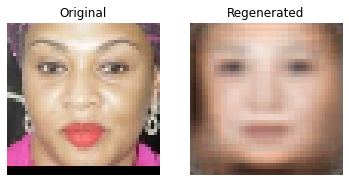

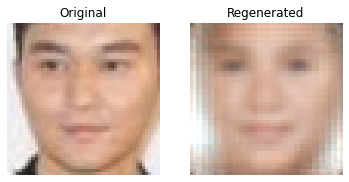

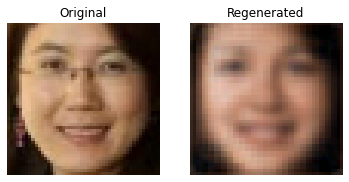

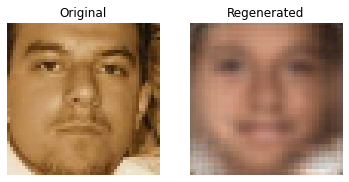

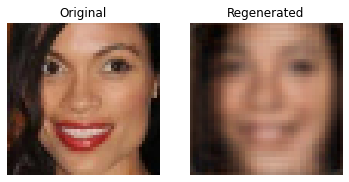

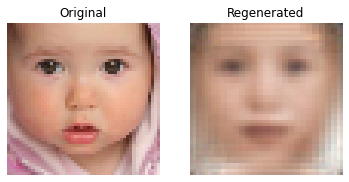

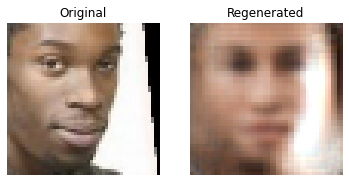

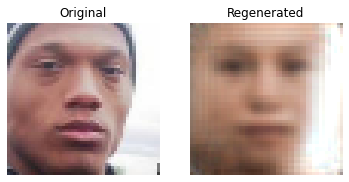

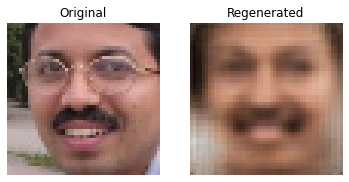

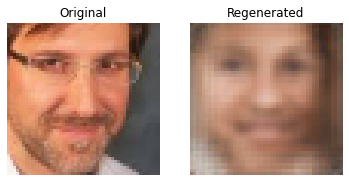

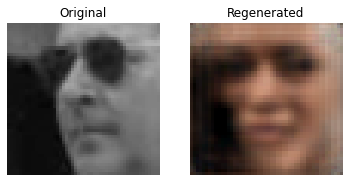

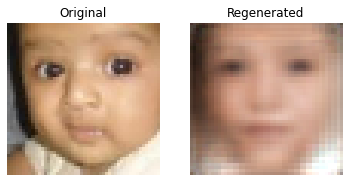

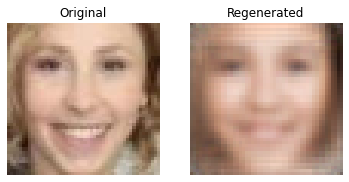

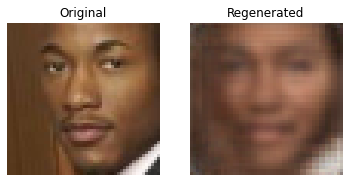

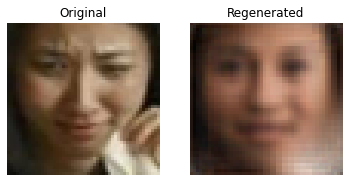

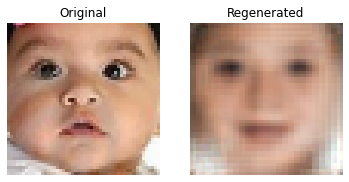

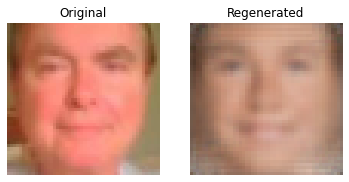

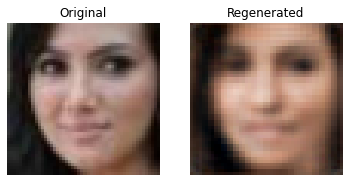

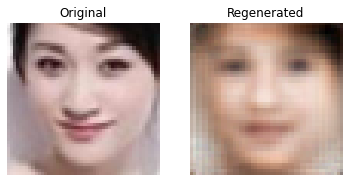

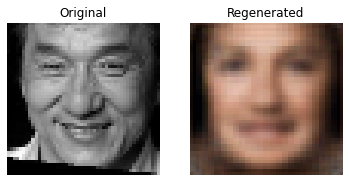

In [17]:
for i in range(test.shape[0]):
    plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original')
    plt.axis('off')
    plt.imshow(test[i])
    
    plt.subplot(1,2,2)
    plt.title('Regenerated')
    plt.axis('off')
    plt.imshow(preds[i])


## Transfer Learning

INFO:tensorflow:Assets written to: decoder_cnn_50.tf/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 30)


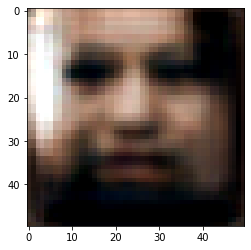

In [38]:
decoder.save('decoder_cnn_50.tf')
test = np.array([[1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1]])
print(test.shape)
ans = decoder.predict(test)
plt.imshow(ans[0])